In [1]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline

# 1. Base MAB Class


In [2]:
class MAB(ABC):
    """    
    Parameters
    ----------
    num_arms: int
        Number of arms.
    """
    def __init__(self, num_arms):
        self.num_arms = num_arms
        
    @abstractmethod
    def play(self, context=None):
        """        
        Parameters
        ----------        
        context: float numpy.ndarray, shape = (n_arms, n_dims)
            An array of context vectors.
            e-greedy and UCB bandits have context = None. 
        Returns
        -------
        arm: int
            Index of arm.
        """
        self.context = context

    
    @abstractmethod
    def update(self, arm, reward, context):
        """        
        Parameters
        ----------
        arm: int
            Index of arm.
        
        reward: float
            Reward received from the arm.
        
        context: float numpy.ndarray, shape = (n_arms, n_dims)
            An array of context vectors.
            e-greedy and UCB bandits have context = None. 
        """
        # Update parameters
        self.arm = arm
        self.reward = reward
        self.context = context

# Non-contextual MABs
### I. ε-greedy

In [3]:
class EGreedy(MAB):
    """
    Parameters
    ----------
    num_arms: int
        Number of arms

    epsilon: float
        Explore probability. Must be in the interval [0, 1].
    """
    # initialise values and raise input errors
    def __init__(self, num_arms, epsilon):  
        super().__init__(num_arms)
        self.epsilon = epsilon
        self.avg = np.ones(self.num_arms)*np.inf  # mean observed reward of each arm
        self.rewards = np.zeros(num_arms)  # cummulative reward of each arm
        self.T = np.zeros(num_arms)   # number of times each arm is chosen
    
    # ε-greedy policy
    def play(self, context=None):
        super().play(context)
        if np.random.rand() < self.epsilon:
            arm = np.random.randint(0, self.num_arms)
        else:
            arm = np.random.choice(np.where(self.avg==max(self.avg))[0])  # random tie-breaking
        return arm
    
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.T[arm] += 1
        self.rewards[arm] += self.reward
        self.avg[arm] = self.rewards[arm]/self.T[arm]

### II. Upper Confidence Bound (UCB)

In [4]:
class UCB(MAB):
    """
    Parameters
    ----------
    num_arms: int
        Number of arms.
    """
    def __init__(self, num_arms):
        super().__init__(num_arms)
        self.index = np.ones(self.num_arms)*np.inf   # index values of each arm
        self.rewards = np.zeros(num_arms)  # cummulative reward of each arm
        self.avg_rewards = np.zeros(num_arms)  # mean reward of each arm, used in UCB index calculation
        self.T = np.zeros(num_arms)  # number of times each arm is chosen
        self.round = 0  # number of played steps
    
    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.index = np.where(self.T != 0, self.avg_rewards + np.sqrt(np.log(self.round)/self.T), self.index)  # update index value if self.T[arm] = 0, else stay the same
        arm = np.random.choice(np.where(self.index==max(self.index))[0])  # random tie-breaking
        return arm
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.T[arm] += 1
        self.rewards[arm] += self.reward
        self.avg_rewards[arm] = self.rewards[arm]/self.T[arm]
        

# Contextual MABs
### I. Linear UCB

In [5]:
class LinUCB(MAB):
    """
    Parameters
    ----------
    num_arms : int
        Number of arms.

    dim : int
        Number of features for each arm's context.

    a : float
        alpha explore-exploit parameter.
    """
    def __init__(self, num_arms, dim, a):
        super().__init__(num_arms) 
        self.dim = dim
        self.alpha = a
        self.posdist = np.zeros(dim)

        self.A = np.array(np.identity(dim))
        self.inv_A = [inv(self.A)]*10
        self.A  = [self.A]*10

        self.b = [np.zeros(dim)]*10
        self.theta = [(inv(np.identity(dim))@np.zeros(dim))]*10
         
    def play(self, context):
        super().play(context)
        for arm in range(self.num_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]
            # calculate posterior distribution of the coefficient vector
            self.posdist[arm] = theta@context[arm] + self.alpha*np.sqrt(context[arm].T@inv_A@context[arm])
            
        arm = np.random.choice(np.where(self.posdist==max(self.posdist))[0])
        return arm
    
    # update dictionary
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]

## 2. Load dataset
The dataset `dataset.txt` contains 10,000 instances of users and news articles. Each instance contains 102 columns with the following information:
 - Column 1: The arm played by a uniformly-random policy.
 - Column 2: The reward received from the arm played.
 - Columns 3-102: 100-dim flattened context vectors; 10 features per arm for 10 arms.


In [6]:
# load dataset and initialize arms, rewards and contexts vectors
data = np.loadtxt("dataset.txt")
chosen_arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

chosen_arms = chosen_arms.astype(int)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
num_arms = len(np.unique(chosen_arms))
print("Number of arms is:", num_arms)

num_events = len(contexts)
dim = int(len(contexts[0])/num_arms)
print("Number of contexts for each arm is:", dim)
contexts = contexts.reshape(num_events, num_arms, dim)
print("Context vectors of 10 arms for the first instance is:")
print(contexts[0])

Number of arms is: 10
Number of contexts for each arm is: 10
Context vectors of 10 arms for the first instance is:
[[ 5.  0.  0. 37.  6.  0.  0.  0.  0. 25.]
 [ 0.  0.  7.  1.  0.  0.  0. 13.  2.  0.]
 [ 0.  8.  0.  0.  0. 15. 29.  1.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  5.  2.  7.  0.  0.  0.  0. 11.  0.]
 [ 5.  0.  0.  0.  0.  0.  0.  3.  2.  0.]
 [ 0.  0.  0.  1.  2. 47.  0.  0.  1.  0.]
 [ 0.  0.  1.  3.  0.  0. 17. 30.  4.  0.]]


## 3. Off-policy evaluation

In [7]:
def OPE(mab, arms, rewards, contexts, n_rounds=800):
    """    
    Parameters
    ----------
    mab: MAB 
        MAB instance to evaluate.
    
    arms: int numpy.ndarray
        Array containing the history of pulled arms.
    
    rewards: float numpy.ndarray
        Array containing the history of rewards.
    
    contexts: float numpy.ndarray
        History of contexts presented to arms. 
        The 0-th axis indexes the events in the history.
        Each event consists of 10 context vectors for the arms.
        
    n_rounds: int
        Desired number of matching arms.
    
    Returns
    -------
    out: float numpy.ndarray
        Rewards for the matching events.
    """
    t = 0         # current round
    R = []        # total reward
    history = []  # used historical events
    matches_count = 0
    n_events = arms.shape[0]
    # play until we have n_rounds of matching arms or until we run out of data
    for i in range(n_events):
        if t == n_rounds:
            break
        chosen_arm = mab.play(contexts[i])
        # update parameters and play only when chosen arm matches arm in data
        # print("chosen arm: {}, arm: {}".format(chosen_arm, arms[i]))
        if chosen_arm == arms[i]:
            matches_count += 1
            R.append(rewards[i])
            history.append([arms[i], rewards[i], contexts[i]])
            mab.update(arms[i], rewards[i], contexts[i])  # for ε-greedy and UCB, contexts = None
            t += 1
    reward_list = np.array(R)
    return reward_list, matches_count 

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
mab = EGreedy(num_arms, 0.1) 
result_EGreedy, eg_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
print('Epsilon-greedy average reward is: %.4f' % np.mean(result_EGreedy))
print('Number of matches:', eg_matches_count)

Epsilon-greedy average reward is: 0.2062
Number of matches: 800


In [10]:
mab = UCB(num_arms)
result_UCB, ucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
print('UCB average reward: %.4f' % np.mean(result_UCB))
print('Number of matches:', ucb_matches_count)

UCB average reward: 0.1412
Number of matches: 800


In [11]:
mab = LinUCB(num_arms, dim, 1.0)
result_LinUCB, linucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
print('LinUCB average reward: %.4f' % np.mean(result_LinUCB))
print('Number of matches:', linucb_matches_count)

LinUCB average reward: 0.5300
Number of matches: 800


### Parameter Optimization for LinUCB
To obtain the optimal value of hyperparameter $\alpha$ for Linear UCB, we define a range of values for alpha and implement LinUCB for $\alpha$ value, then find the $\alpha$ which yields maximum reward according to off-policy evaluation.

Best value of alpha resulting in maximum average reward is:  0.025595479226995357


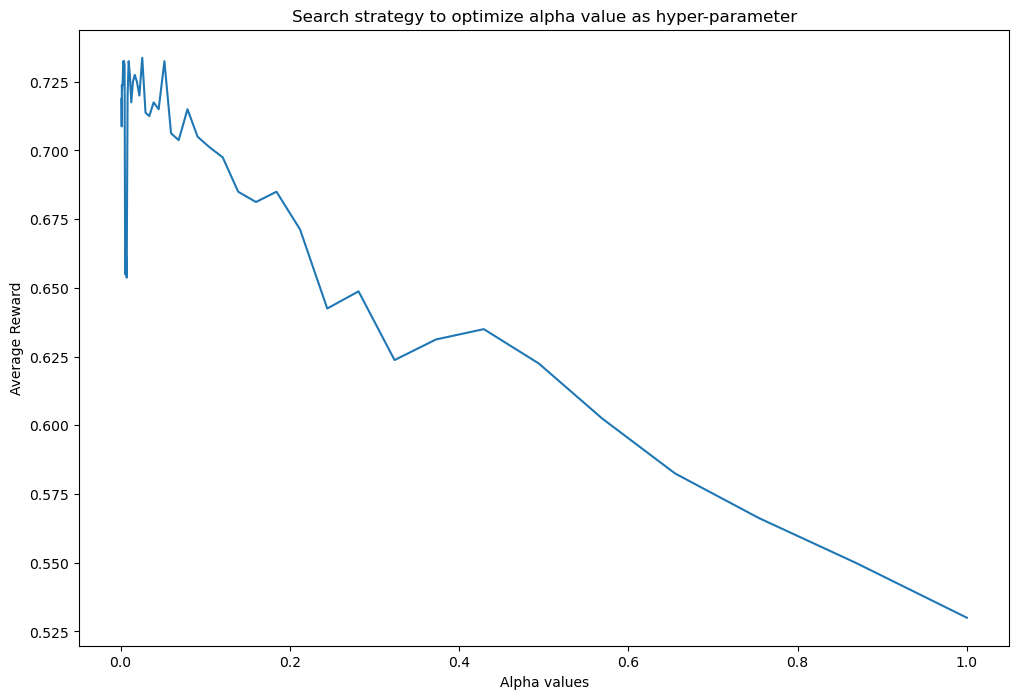

In [12]:
alphas = np.logspace(-3,0,num= 50)# average reward of LinUCB per each alpha value
results = np.zeros(len(alphas))

# Testing alpha values
for alpha in range(len(alphas)):    
    mab = LinUCB(10, 10, alphas[alpha])
    result_LinUCB, linucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
    results[alpha] = np.mean(result_LinUCB)
best_alpha = alphas[np.argmax(results)]
print('Best value of alpha resulting in maximum average reward is: ', best_alpha)

# Plot
plt.figure(figsize=(12,8))
plt.plot(alphas, results, label = "LinUCB with $alpha=x.xx$")
plt.xlabel("Alpha values")
plt.ylabel("Average Reward")
plt.title("Search strategy to optimize alpha value as hyper-parameter")
plt.show()

# 4. Comparison between MABs

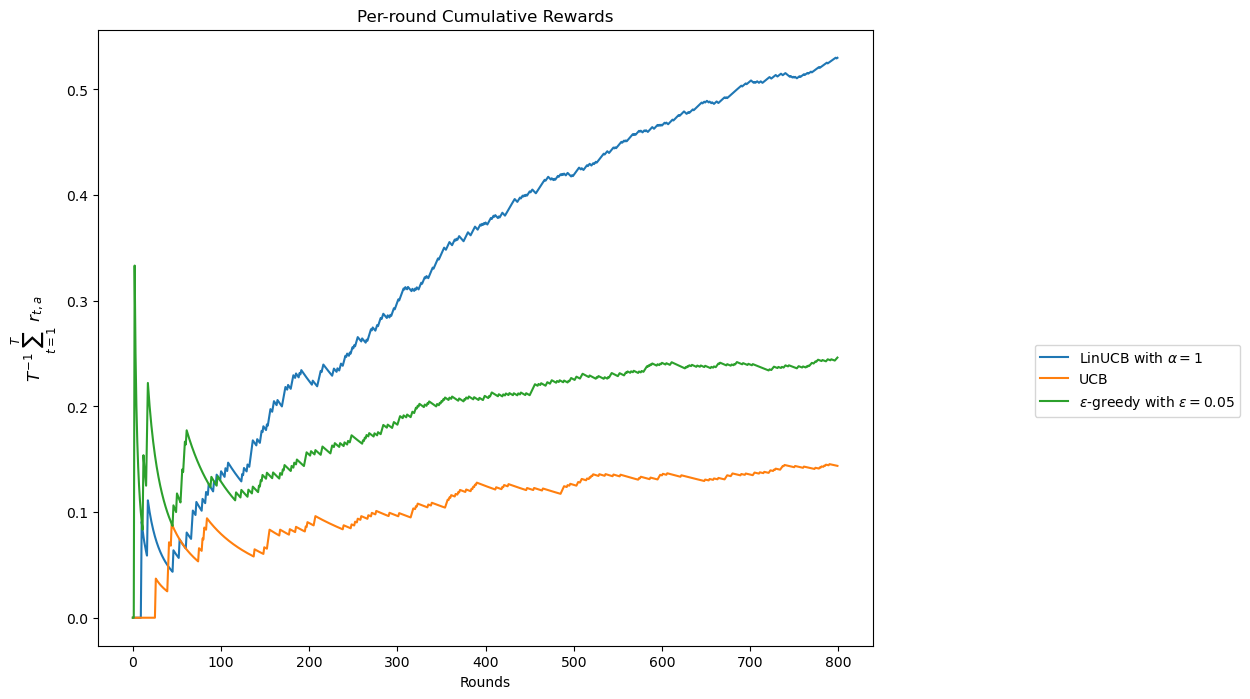

In [13]:
# Epsilon Greedy
mab = EGreedy(10, 0.05)
result_EGreedy, eg_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_EpsGreedy = np.cumsum(result_EGreedy)

# UCB
mab = UCB(10)
result_UCB, ucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_UCB = np.cumsum(result_UCB)

# Linear UCB
mab = LinUCB(10, 10, 1.0)
result_LinUCB, linucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_LinUCB = np.cumsum(result_LinUCB)

# Plots
plt.figure(figsize=(10,8))
plt.plot(cumulative_reward_LinUCB/np.linspace(1,800,800), label = r"LinUCB with $\alpha=1$")
plt.plot(cumulative_reward_UCB/(np.linspace(1,800,800)), label = r"UCB")
plt.plot(cumulative_reward_EpsGreedy/(np.linspace(1,800,800)), label = r"$\epsilon$-greedy with $\epsilon=0.05$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

# Comparison using best $\alpha$ for LinUCB

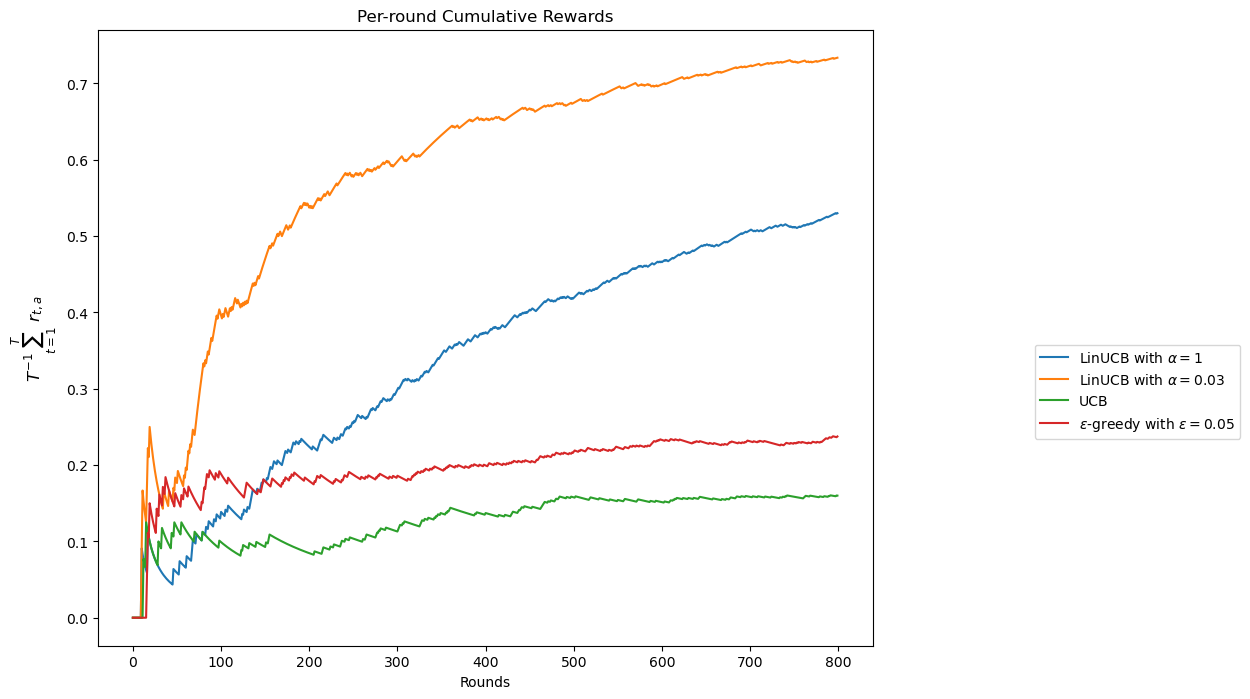

In [14]:
# Epsilon Greedy
mab = EGreedy(10, 0.05)
result_EGreedy, eg_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_EpsGreedy = np.cumsum(result_EGreedy)

# UCB
mab = UCB(10)
result_UCB, ucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_UCB = np.cumsum(result_UCB)

# Linear UCB with alpha = 1
mab = LinUCB(10, 10, a = 1.0)
result_LinUCB1, linucb1_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_LinUCB1 = np.cumsum(result_LinUCB1)

# Linear UCB with best alpha
print("Best alpha is:", best_alpha)
mab = LinUCB(10, 10, a = best_alpha)
result_LinUCB, linucb_matches_count = OPE(mab, chosen_arms, rewards, contexts,)
cumulative_reward_LinUCB = np.cumsum(result_LinUCB)

# Plots
plt.figure(figsize=(10,8))
plt.plot(cumulative_reward_LinUCB1/np.linspace(1,800,800), label = r"LinUCB with $\alpha=1$")
plt.plot(cumulative_reward_LinUCB/np.linspace(1,800,800), label = r"LinUCB with $\alpha=$" + "{0:.2f}".format(best_alpha))
plt.plot(cumulative_reward_UCB/(np.linspace(1,800,800)), label = r"UCB")
plt.plot(cumulative_reward_EpsGreedy/(np.linspace(1,800,800)), label = r"$\epsilon$-greedy with $\epsilon=0.05$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

# Discussion
As expected, non-contextual MABs such as $\epsilon$-greedy and UCB have roughly equal performance with an off-policy reward at around 0.15-0.2. When contexts of arms are considered, algorithms like Linear UCB give a much better result, with its reward at around 0.5.
\
We notice that choice of hyperparameter $\alpha$ for Linear UCB is pivotal, as smaller alpha values give much better results than the usual $\alpha$ = 1. In particular, Linear UCB with $\alpha \approx 0.03$ has an off-policy reward at around 0.7, compared to the 0.5 of a Linear UCB instance with $\alpha$ = 1.